[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 words in disaster tweets:
[('fire', 151), ('via', 117), ('suicide', 103), ('disaster', 97), ('police', 94), ('people', 93), ('killed', 92), ('like', 91), ('california', 88), ('families', 81), ('two', 71), ('storm', 71), ('train', 71), ('bomb', 67), ('emergency', 66), ('get', 66), ('crash', 65), ('one', 63), ('nuclear', 63), ('bombing', 63)]

Top 20 words in non-disaster tweets:
[('like', 250), ('new', 163), ('get', 161), ('one', 116), ('body', 106), ('via', 97), ('would', 94), ('love', 85), ('got', 82), ('people', 81), ('full', 81), ('see', 79), ('know', 78), ('video', 76), ('back', 75), ('emergency', 75), ('going', 73), ('still', 70), ('time', 69), ('want', 65)]


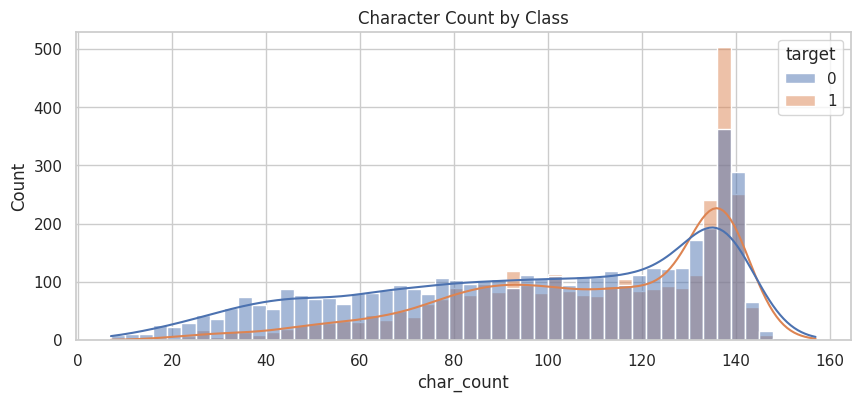

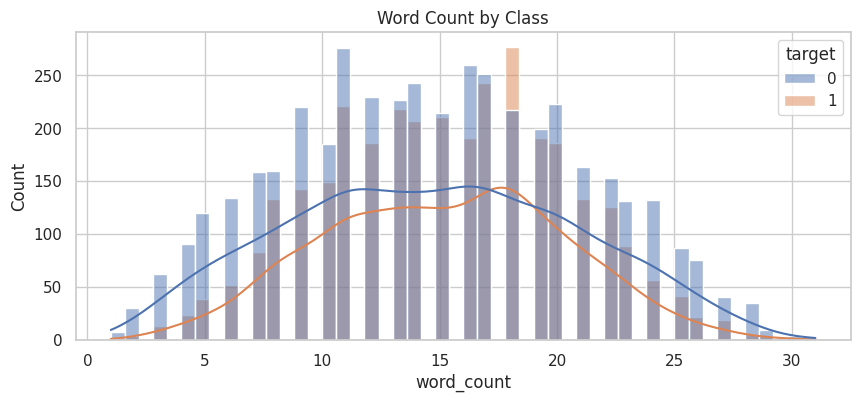

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


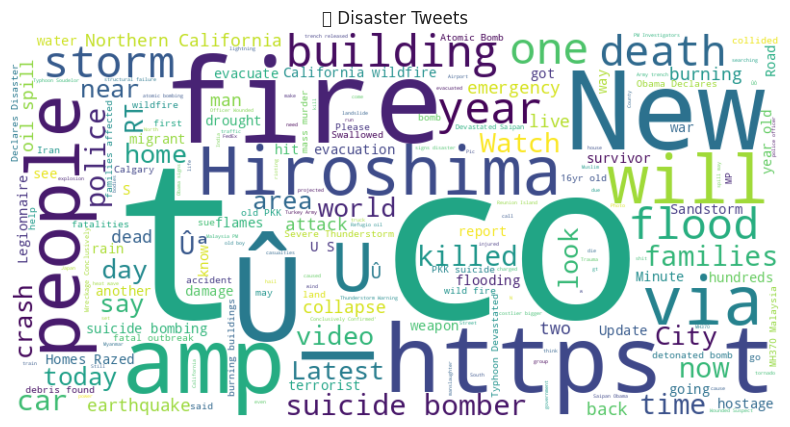

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


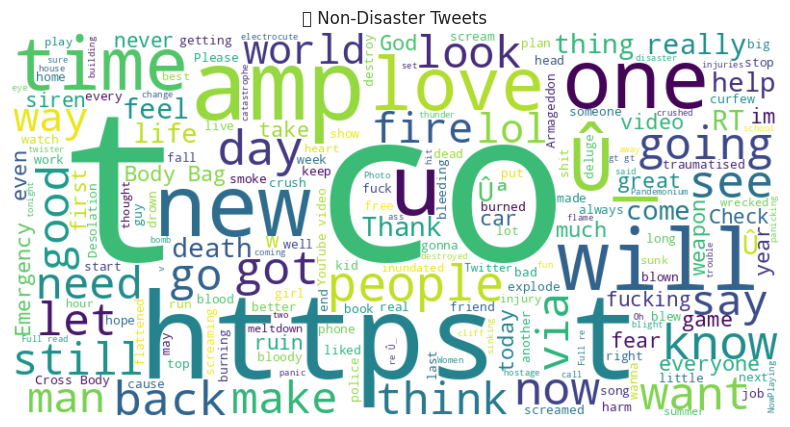

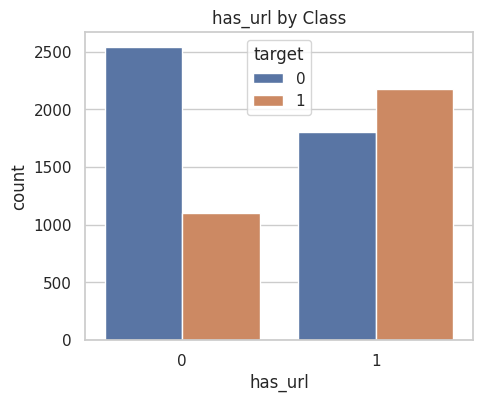

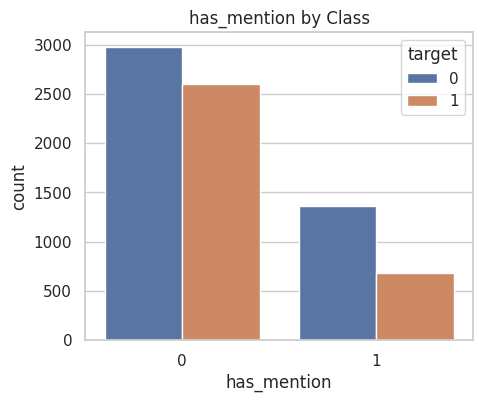

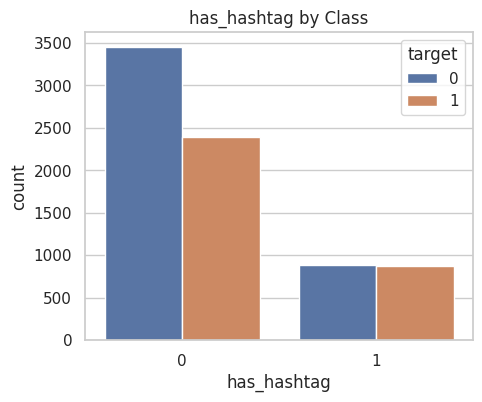

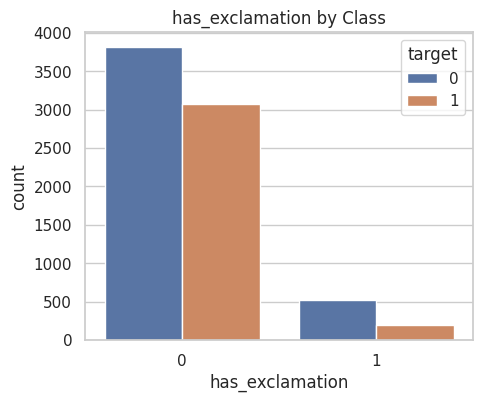

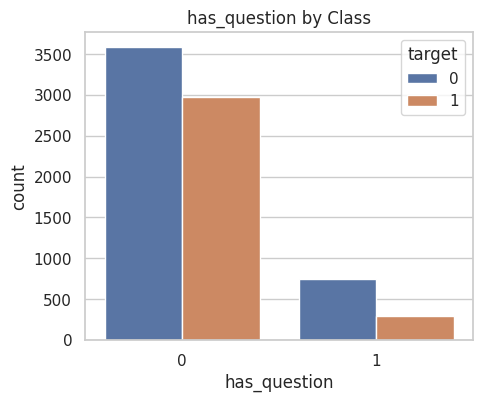

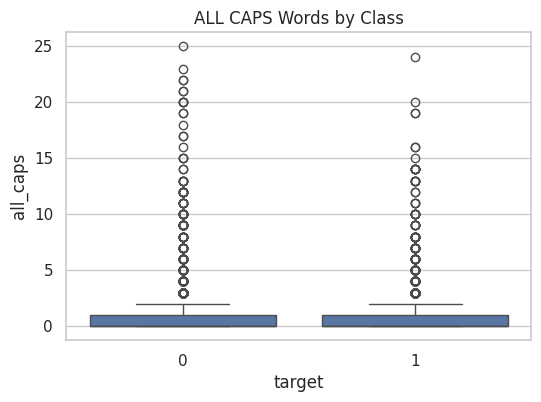

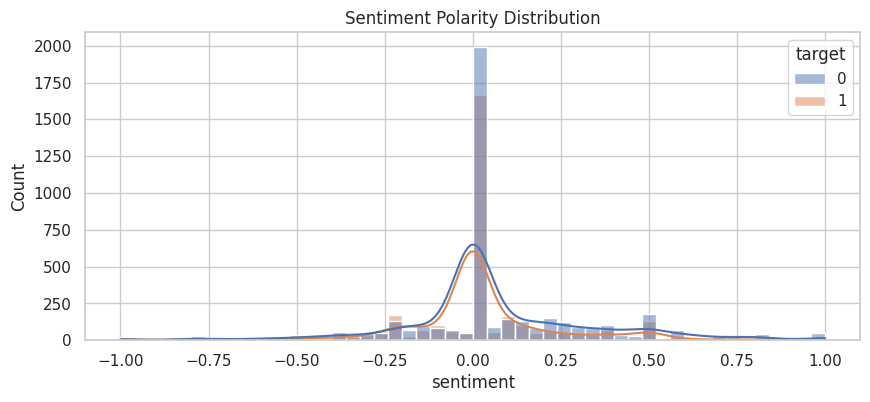

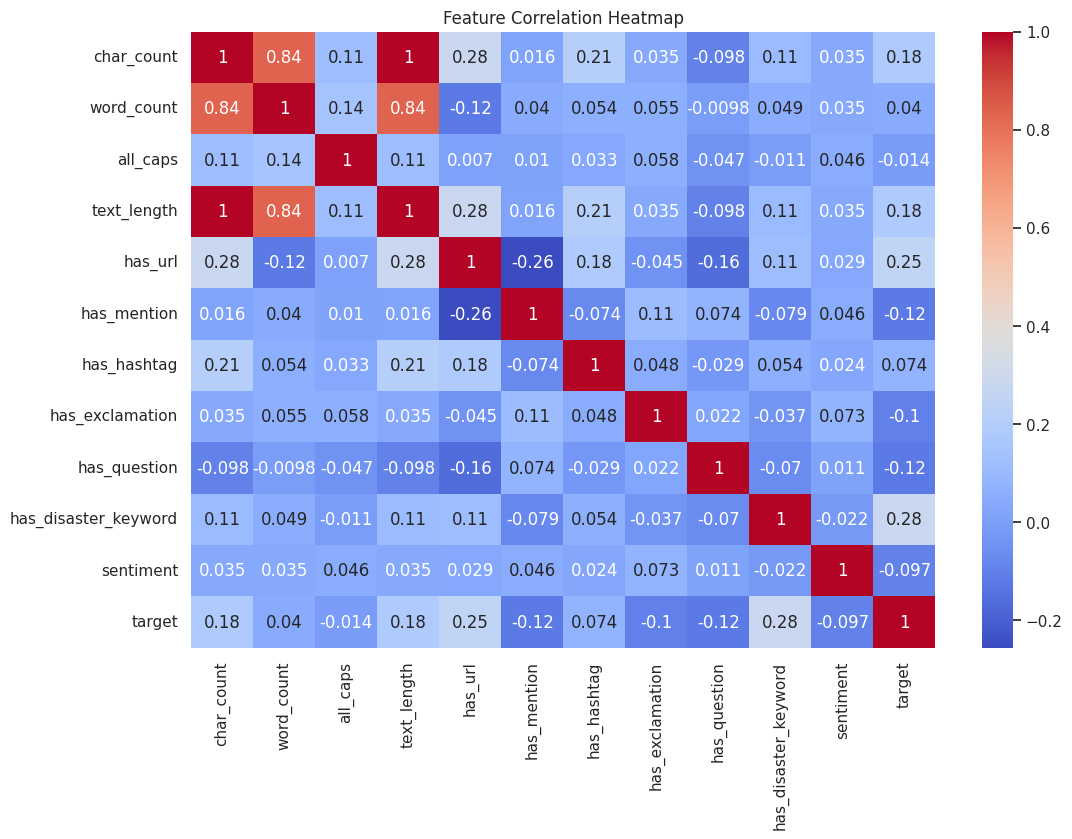

In [ ]:
#資料探索
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
import nltk
import re

# nltk 資源下載
nltk.download('stopwords')
from nltk.corpus import stopwords

# ---------- 1. 載入資料 ----------
train = pd.read_csv("train.csv")

# ---------- 2. 建立基本特徵 ----------
stop_words = set(stopwords.words('english'))

train['char_count'] = train['text'].apply(len)
train['word_count'] = train['text'].apply(lambda x: len(x.split()))
train['has_url'] = train['text'].str.contains('http').astype(int)
train['has_mention'] = train['text'].str.contains('@').astype(int)
train['has_hashtag'] = train['text'].str.contains('#').astype(int)
train['has_exclamation'] = train['text'].str.contains('!').astype(int)
train['has_question'] = train['text'].str.contains(r'\?').astype(int)
train['all_caps'] = train['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
train['text_length'] = train['text'].str.len()

# ---------- 3. 加入災難關鍵字特徵 ----------
disaster_keywords = [
    'fire', 'flood', 'earthquake', 'storm', 'hurricane', 'typhoon', 'killed',
    'dead', 'died', 'explosion', 'crash', 'emergency', 'rescue', 'evacuate',
    'tsunami', 'fatal', 'injured', 'wreck'
]
train['has_disaster_keyword'] = train['text'].str.lower().apply(
    lambda x: int(any(keyword in x for keyword in disaster_keywords))
)

# ---------- 4. Sentiment 特徵 ----------
train['sentiment'] = train['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# ---------- 5. 常見字詞統計 ----------
def get_top_words(texts, n=20):
    words = ' '.join(texts).lower().split()
    words = [w for w in words if w not in stop_words and w.isalpha()]
    return Counter(words).most_common(n)

print("Top 20 words in disaster tweets:")
print(get_top_words(train[train['target'] == 1]['text']))
print("\nTop 20 words in non-disaster tweets:")
print(get_top_words(train[train['target'] == 0]['text']))

# ---------- 6. 資料視覺化 ----------

sns.set(style="whitegrid")

# --- (a) 字數與詞數 ---
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='char_count', hue='target', bins=50, kde=True)
plt.title("Character Count by Class")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=train, x='word_count', hue='target', bins=50, kde=True)
plt.title("Word Count by Class")
plt.show()

# --- (b) WordCloud ---
def show_wordcloud(data, title):
    text = ' '.join(data)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_wordcloud(train[train['target'] == 1]['text'], "🚨 Disaster Tweets")
show_wordcloud(train[train['target'] == 0]['text'], "📢 Non-Disaster Tweets")

# --- (c) 特徵統計圖 ---
features = ['has_url', 'has_mention', 'has_hashtag', 'has_exclamation', 'has_question']
for feature in features:
    plt.figure(figsize=(5,4))
    sns.countplot(x=feature, hue='target', data=train)
    plt.title(f"{feature} by Class")
    plt.show()

# --- (d) ALL CAPS 散布 ---
plt.figure(figsize=(6,4))
sns.boxplot(x='target', y='all_caps', data=train)
plt.title("ALL CAPS Words by Class")
plt.show()

# --- (e) Sentiment ---
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='sentiment', hue='target', bins=50, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.show()

# --- (f) 特徵間相關性 ---
correlation_features = [
    'char_count', 'word_count', 'all_caps', 'text_length',
    'has_url', 'has_mention', 'has_hashtag',
    'has_exclamation', 'has_question', 'has_disaster_keyword',
    'sentiment', 'target'
]
plt.figure(figsize=(12,8))
sns.heatmap(train[correlation_features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# 安裝必要套件
!pip install transformers
!pip install nltk
!pip install --upgrade sympy


# 匯入函式庫
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# 載入資料
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

Using device: cpu


In [ ]:
import re
from nltk.corpus import stopwords
from collections import Counter
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. 簡單 tokenize 函式
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#', '', text)
    tokens = re.findall(r'\b\w+\b', text)
    return [t for t in tokens if t not in stop_words and len(t) > 2]

# 2. 從 target=1 的文本中提取災難關鍵詞
disaster_texts = train[train['target'] == 1]['text'].tolist()
all_words = []

for text in disaster_texts:
    all_words.extend(simple_tokenize(text))

# 3. 取得高頻詞前 N 個作為災難關鍵詞
top_n = 20
disaster_keywords = [word for word, freq in Counter(all_words).most_common(top_n)]

print("🔍 Top disaster keywords:", disaster_keywords)

# 4. 判斷文本是否含有災難關鍵詞
def contains_disaster_keyword(text):
    text_lower = text.lower()
    return int(any(keyword in text_lower for keyword in disaster_keywords))

train['has_disaster_keyword'] = train['text'].apply(contains_disaster_keyword)
test['has_disaster_keyword'] = test['text'].apply(contains_disaster_keyword)

# 5. 清理文字
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '[URL]', text)
    text = re.sub(r'@\w+', '[MENTION]', text)
    text = re.sub(r'#(\w+)', r'[HASHTAG] \1', text)
    text = re.sub(r'!', '[EXCLAMATION]', text)
    text = re.sub(r'\?', '[QUESTION]', text)
    text = text.lower()
    text = re.sub(r'[^\w\s\[\]]', '', text)  # 保留自定義 token
    return text

train['text_clean'] = train['text'].astype(str).apply(clean_text)
test['text_clean'] = test['text'].astype(str).apply(clean_text)

# 6. 在文字尾部加上 meta token
def add_meta_tokens(row):
    tokens = []

    if row['has_disaster_keyword']:
        tokens.append('[DISASTER_KEYWORD]')
    # 若還有其他 feature，如 has_question, has_exclamation，可一併加上

    return row['text_clean'] + ' ' + ' '.join(tokens)

train['text_clean'] = train.apply(add_meta_tokens, axis=1)
test['text_clean'] = test.apply(add_meta_tokens, axis=1)

# 7. 轉成列表給 tokenizer 用
train_texts = train['text_clean'].tolist()
train_labels = train['target'].tolist()
test_texts = test['text_clean'].tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🔍 Top disaster keywords: ['fire', 'news', 'amp', 'disaster', 'via', 'california', 'suicide', 'police', 'people', 'killed', 'like', 'hiroshima', 'storm', 'crash', 'fires', 'families', 'train', 'emergency', 'bomb', 'buildings']
